In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle

from tqdm import tqdm

from flash_ansr import get_path
from flash_ansr.eval.utils import bootstrapped_metric_ci

In [2]:
# This is where the results are stored
PATH_TO_EVALUATION_DATA = get_path('results', 'evaluation')
os.path.exists(PATH_TO_EVALUATION_DATA)

True

In [3]:
# We will compare multiple series of experiments here, each model with different amounts of test time compute.
results = {
    # 'PySR': {'scaling_parameter': 'niterations'},
    'v20.0-60M': {'scaling_parameter': 'choices'},
}

In [4]:
for model in results.keys():
    print(f"Processing model {model}")
    if not 'scaling_parameter' in results[model]:
        raise ValueError("Please specify the scaling parameter for the model.")
    scaling_parameter = results[model]['scaling_parameter']

    # In the directory, there are multiple directories named "evaluation_<scaling_parameter_name>_<scaling_parameter_value>.yaml",
    # each each containing files "<test_set_name>.pickle" with the evaluation results for a specific test set.
    evaluations_list = os.listdir(os.path.join(PATH_TO_EVALUATION_DATA, f'{model}_{scaling_parameter}'))

    evaluations_list = [d for d in evaluations_list if d.startswith(f'evaluation_{scaling_parameter}_')]
    scaling_values = [int(d.split('_')[-1].split('.')[0]) for d in evaluations_list]

    scaling_values_argsort = np.argsort(scaling_values)
    scaling_values = [scaling_values[i] for i in scaling_values_argsort]
    evaluations_list = [evaluations_list[i] for i in scaling_values_argsort]

    results[model]['scaling_values'] = scaling_values
    results[model]['evaluations_list'] = evaluations_list
    results[model]['results'] = {}

    print(f"Found {len(evaluations_list)} evaluations with scaling values: {scaling_values}")
    for d in evaluations_list:
        print(f" - {d}")

Processing model v20.0-60M
Found 6 evaluations with scaling values: [1, 2, 16, 32, 64, 128]
 - evaluation_choices_1
 - evaluation_choices_2
 - evaluation_choices_16
 - evaluation_choices_32
 - evaluation_choices_64
 - evaluation_choices_128


In [5]:
TEST_SETS_FILTER = ['pool_15_10']

In [6]:
# Load the evaluation results
for model in results.keys():
    scaling_parameter = results[model]['scaling_parameter']
    for d in tqdm(results[model]['evaluations_list'], desc="Loading evaluation results"):
        for test_set in TEST_SETS_FILTER:
            path_to_pickle = os.path.join(PATH_TO_EVALUATION_DATA, f'{model}_{scaling_parameter}', d, f"{test_set}.pickle")
            if not os.path.exists(path_to_pickle):
                print(f"Warning: {path_to_pickle} does not exist. Skipping.")
                continue
            with open(path_to_pickle, 'rb') as f:
                result = pickle.load(f)
            niterations = int(d.split('_')[-1].split('.')[0])
            if test_set not in results[model]['results']:
                results[model]['results'][test_set] = {}
            results[model]['results'][test_set][niterations] = result

    print(results[model]['results'].keys())

Loading evaluation results: 100%|██████████| 6/6 [00:01<00:00,  4.77it/s]

dict_keys(['pool_15_10'])


In [7]:
DEFAULT_NEGATIVES = {
    'constants': [],
    'error': None,
    'expression': [],
    'fit_time': np.inf,
    'input_ids': [],
    'labels': [],
    'labels_decoded': [],
    'n_support': np.nan,
    'parsimony': np.nan,
    'predicted_constants': [],
    'predicted_expression': [],
    'predicted_expression_encoded': [],
    'predicted_expression_prefix': [],
    'predicted_expression_simplified': [],
    'predicted_score': -np.inf,
    'predicted_log_prob': -np.inf,
    'prediction_success': False,
    'skeleton': [],
    'skeleton_hash': [],
    'x': np.nan,
    'x_val': np.nan,
    'y': np.nan,
    'y_noisy': np.nan,
    'y_noisy_val': np.nan,
    'y_pred': np.nan,
    'y_pred_val': np.nan,
    'y_val': np.nan,
}

In [8]:
for model in results.keys():
    for test_set in results[model]['results'].keys():
        for niterations in results[model]['results'][test_set].keys():
            for metric in results[model]['results'][test_set][niterations].keys():
                try:
                    results[model]['results'][test_set][niterations][metric] = np.array([(DEFAULT_NEGATIVES[metric] if r is None else r) for r in results[model]['results'][test_set][niterations][metric]])
                except ValueError:
                    pass  # setting an array element with a sequence

In [9]:
results.keys()

dict_keys(['v20.0-60M'])

In [10]:
print(results['v20.0-60M']['results']['pool_15_10'][1].keys())

dict_keys(['constants', 'error', 'expression', 'fit_time', 'input_ids', 'labels', 'labels_decoded', 'n_support', 'parsimony', 'predicted_constants', 'predicted_expression', 'predicted_expression_encoded', 'predicted_expression_prefix', 'predicted_expression_simplified', 'predicted_log_prob', 'predicted_score', 'prediction_success', 'skeleton', 'skeleton_hash', 'x', 'x_val', 'y', 'y_noisy', 'y_noisy_val', 'y_pred', 'y_pred_val', 'y_val'])


In [11]:
from flash_ansr.eval.token_prediction import f1_score

In [12]:
def safe_divide(a, b):
    if b == 0:
        if a == 0:
            return 0
        return np.inf
    if np.isnan(a) or np.isnan(b):
        return np.nan
    if not np.isfinite(a) or not np.isfinite(b):
        print(a, b)
    return a / b

def fvu(y_true, y_pred):
    if y_pred is None or y_true is None:
        return np.inf
    y_pred = y_pred.astype(np.float64)
    y_true = y_true.astype(np.float64)
    scale = 1 / np.mean((y_true - y_pred) ** 2)
    ss_res = np.mean((y_true * scale - y_pred * scale) ** 2)
    ss_tot = np.mean((y_true * scale - np.mean(y_true * scale, keepdims=True)) ** 2)
    fvu = safe_divide(ss_res, ss_tot)
    return fvu

def log10_fvu(y_true, y_pred):
    fvu_value = fvu(y_true, y_pred)
    if fvu_value == 0:
        return -np.inf
    return np.log10(fvu_value)

def is_perfect_fit(y_true, y_pred):
    return fvu(y_true, y_pred) <= np.finfo(np.float32).eps


for model in results.keys():
    for test_set in results[model]['results'].keys():
        for scaling_value in results[model]['results'][test_set].keys():
            for split, saved_split_name in zip(['fit', 'val'], ['', '_val']):
                results[model]['results'][test_set][scaling_value][f'fvu_{split}'] = np.array(
                    [fvu(y_true, y_pred) for y_true, y_pred in zip(
                        results[model]['results'][test_set][scaling_value][f'y{saved_split_name}'],
                        results[model]['results'][test_set][scaling_value][f'y_pred{saved_split_name}'])])
                
                results[model]['results'][test_set][scaling_value][f'log10_fvu_{split}'] = np.array(
                    [log10_fvu(y_true, y_pred) for y_true, y_pred in zip(
                        results[model]['results'][test_set][scaling_value][f'y{saved_split_name}'],
                        results[model]['results'][test_set][scaling_value][f'y_pred{saved_split_name}'])])
                                
                results[model]['results'][test_set][scaling_value][f'numeric_recovery_{split}'] = np.array(
                    [is_perfect_fit(y_true, y_pred) for y_true, y_pred in zip(
                        results[model]['results'][test_set][scaling_value][f'y{saved_split_name}'],
                        results[model]['results'][test_set][scaling_value][f'y_pred{saved_split_name}'])])
                
            results[model]['results'][test_set][scaling_value]['f1_score'] = np.array(
                [f1_score(
                    np.array([results[model]['results'][test_set][scaling_value]['predicted_expression_simplified'][i]]),
                    np.array([results[model]['results'][test_set][scaling_value]['expression'][i]])) for i in range(len(results[model]['results'][test_set][scaling_value]['expression']))])
            
            results[model]['results'][test_set][scaling_value]['expression_length'] = np.array(
                [len(expr) if expr is not None else np.nan for expr in results[model]['results'][test_set][scaling_value]['expression']])
            
            results[model]['results'][test_set][scaling_value]['n_variables'] = np.array(
                [len(set(token for token in expr if token.startswith('x'))) if expr is not None else np.nan for expr in results[model]['results'][test_set][scaling_value]['expression']])
            
            results[model]['results'][test_set][scaling_value][f'symbolic_recovery'] = np.array(
                [results[model]['results'][test_set][scaling_value]['predicted_expression_prefix'][i] == results[model]['results'][test_set][scaling_value]['expression'][i] for i in range(len(results[model]['results'][test_set][scaling_value]['expression']))])

            results[model]['results'][test_set][scaling_value][f'expression_length_ratio'] = np.array(
                [safe_divide(len(results[model]['results'][test_set][scaling_value]['predicted_expression_simplified'][i]) if results[model]['results'][test_set][scaling_value]['predicted_expression_simplified'][i] is not None else np.nan,
                             len(results[model]['results'][test_set][scaling_value]['expression'][i]) if results[model]['results'][test_set][scaling_value]['expression'][i] is not None else np.nan)
                 for i in range(len(results[model]['results'][test_set][scaling_value]['expression']))])

print(results['v20.0-60M']['results']['pool_15_10'][1]['fvu_val'][:4])

/tmp/ipykernel_906/2927650187.py:17: RuntimeWarning: divide by zero encountered in scalar divide
  scale = 1 / np.mean((y_true - y_pred) ** 2)
/tmp/ipykernel_906/2927650187.py:18: RuntimeWarning: invalid value encountered in subtract
  ss_res = np.mean((y_true * scale - y_pred * scale) ** 2)
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.13/site-packages/numpy/_core/_methods.py:134: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/tmp/ipykernel_906/2927650187.py:19: RuntimeWarning: invalid value encountered in subtract
  ss_tot = np.mean((y_true * scale - np.mean(y_true * scale, keepdims=True)) ** 2)
/tmp/ipykernel_906/2927650187.py:18: RuntimeWarning: invalid value encountered in multiply
  ss_res = np.mean((y_true * scale - y_pred * scale) ** 2)
/tmp/ipykernel_906/2927650187.py:19: RuntimeWarning: invalid value encountered in multiply
  ss_tot = np.mean((y_true * scale - np.mean(y_true * scale, keepdims=True)) *

[           nan 1.74132281e-15 5.23026675e-04 1.66648385e-12]


In [13]:
results['v20.0-60M']['results']['pool_15_10'][1]['fvu_val'].shape, results['v20.0-60M']['results']['pool_15_10'][1]['fit_time'].shape

((4096,), (4096,))

In [14]:
def arrow_notation(objective: int = 1, lower: float | str = 0, upper: float | str = 1, lower_open: bool = False, upper_open: bool = False):
    lower_bracket = '(' if lower_open else '['
    upper_bracket = ')' if upper_open else ']'

    if lower == -np.inf:
        lower_bracket = '('
        lower = '-\\infty'
    if upper == np.inf:
        upper_bracket = ')'
        upper = '\\infty'

    try:
        float(lower)
        lower = f"{lower:.2g}"
    except:
        pass

    try:
        float(upper)
        upper = f"{upper:.2g}"
    except:
        pass

    if objective == 1:
        return f"\\uparrow^{{{lower_bracket}{lower}, {upper}{upper_bracket}}}"
    elif objective == -1:
        return f"\\downarrow^{{{lower_bracket}{lower}, {upper}{upper_bracket}}}"
    else:
        raise ValueError("Objective must be 1 (higher is better) or -1 (lower is better).")

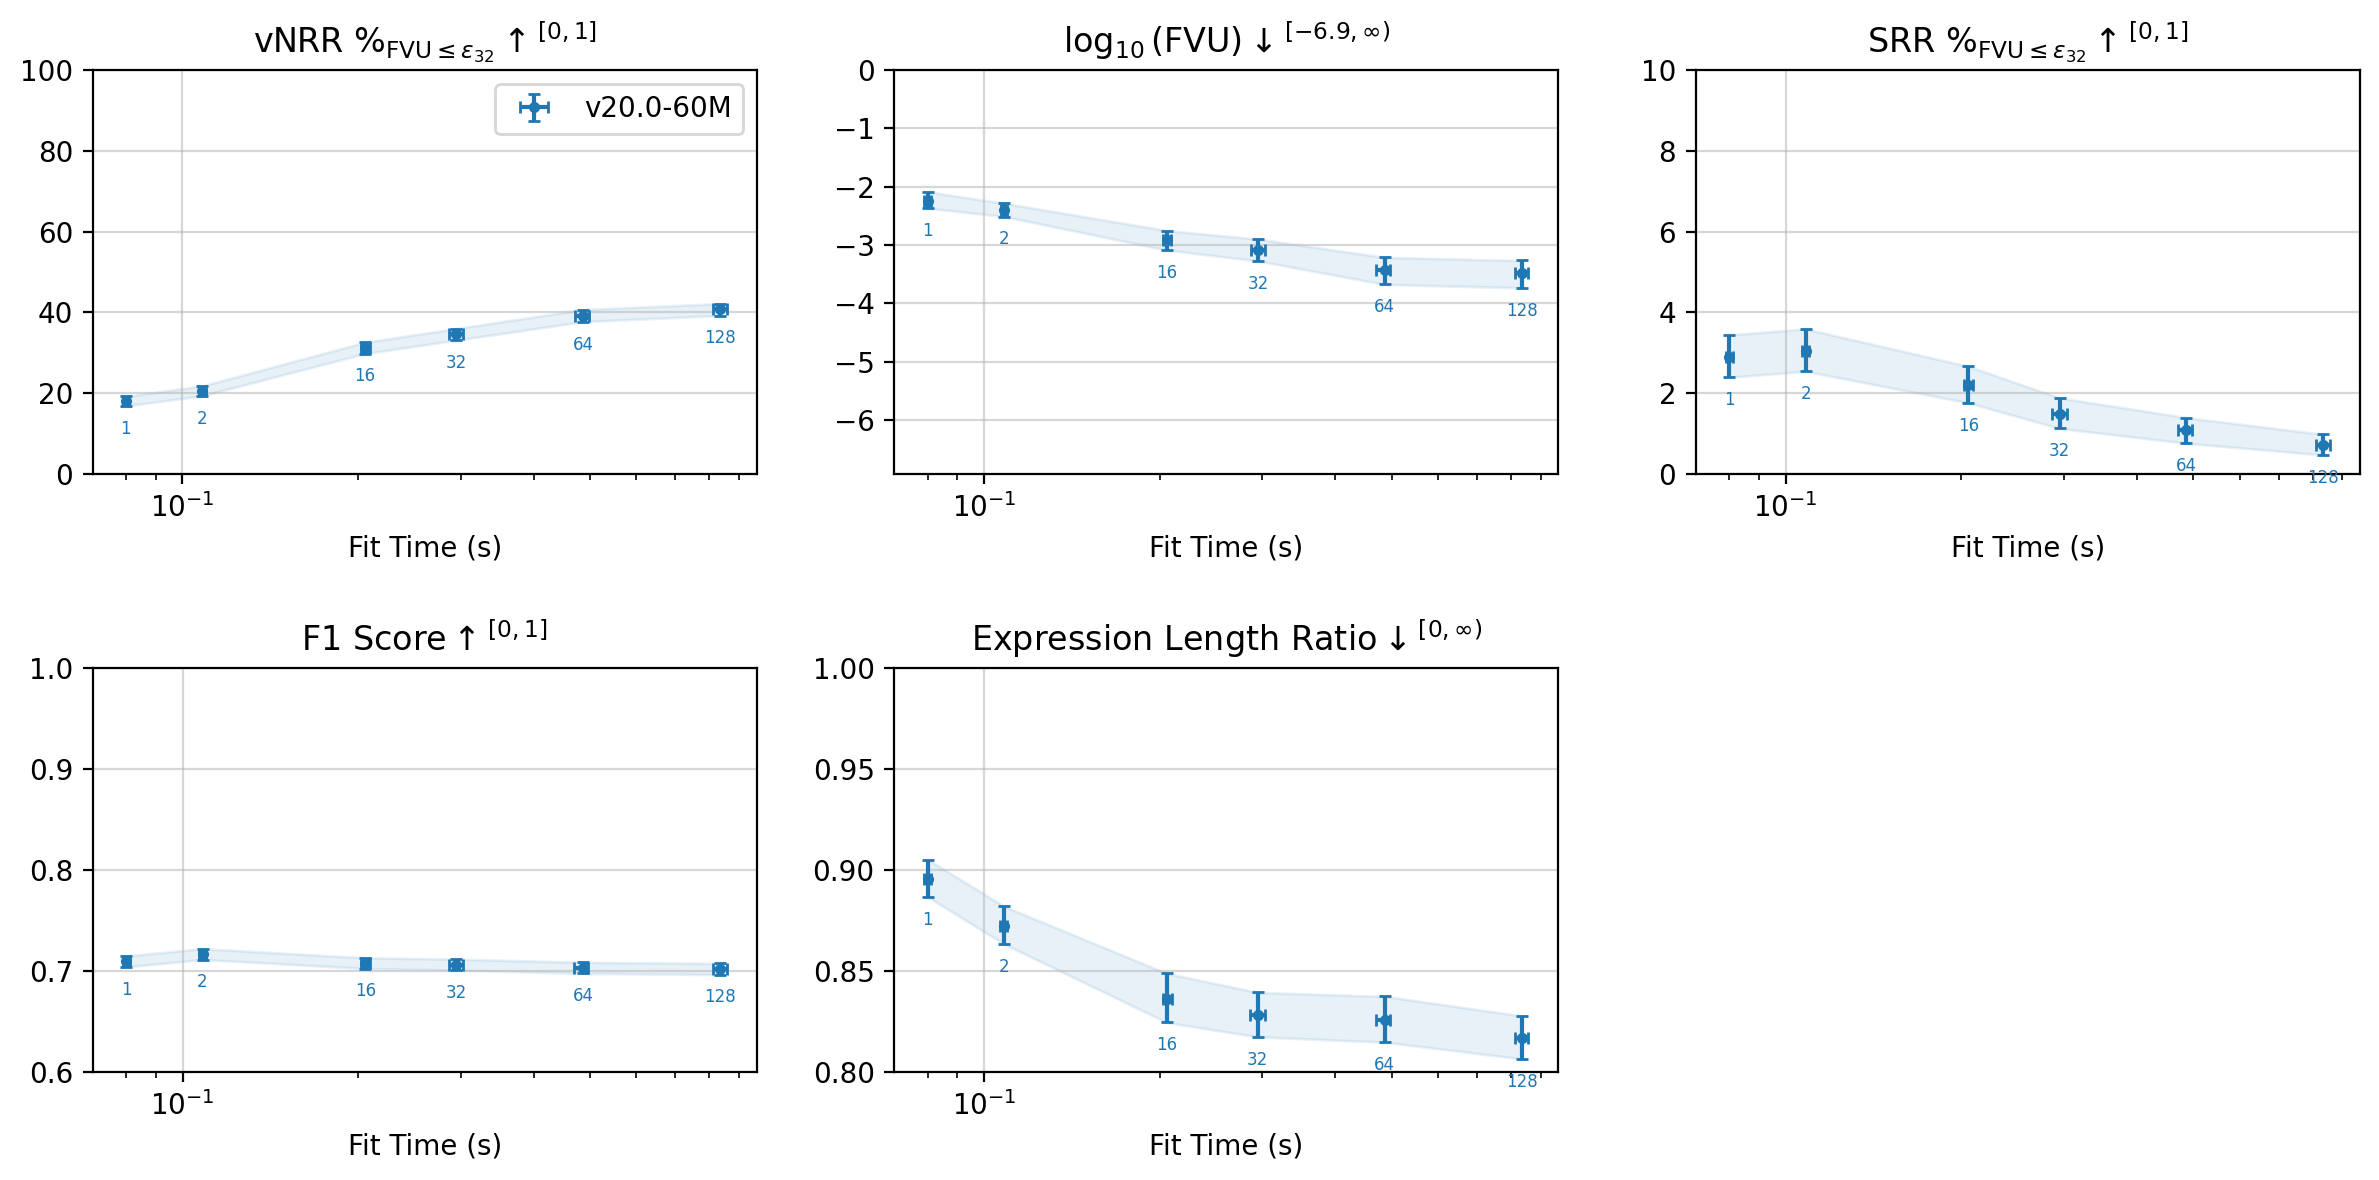

In [ ]:
metric_pairs = [
    (('fit_time', 'Fit Time (s)', np.nanmedian), (
        'numeric_recovery_val',
        f'vNRR $\\%_{{\\mathrm{{FVU}} \leq \epsilon_{{32}}}} {arrow_notation(objective=1, lower=0, upper=1)}$',
        np.nanmean,
        100,
        (0, 100)
    )),
    (('fit_time', 'Fit Time (s)', np.nanmedian), (
        'log10_fvu_val',
        f'$\\log_{{10}}(\mathrm{{FVU}}) {arrow_notation(objective=-1, lower=np.log10(np.finfo(np.float32).eps), upper=np.inf)}$',
        np.nanmedian,
        1,
        (np.log10(np.finfo(np.float32).eps),0)
    )),
    (('fit_time', 'Fit Time (s)', np.nanmedian), (
        'symbolic_recovery',
        f'SRR $\\%_{{\\mathrm{{FVU}} \leq \epsilon_{{32}}}} {arrow_notation(objective=1, lower=0, upper=1)}$',
        np.nanmean,
        100,
        (0, 10)
    )),
    (('fit_time', 'Fit Time (s)', np.nanmedian), (
        'f1_score',
        f'$\mathrm{{F1\\ Score}} {arrow_notation(objective=1, lower=0, upper=1)}$',
        np.nanmean,
        1,
        (0.6, 1)
    )),
    (('fit_time', 'Fit Time (s)', np.nanmedian), (
        'expression_length_ratio',
        f'$\mathrm{{Expression\\ Length\\ Ratio}} {arrow_notation(objective=-1, lower=0, upper=np.inf)}$',
        np.nanmean,
        1,
        (0.7, 1)
    )),
]

models = [
    # ('PySR', 'niterations', 'tab:red'),
    ('v20.0-60M', 'choices', 'tab:blue'),
]

COLS = 3
ROWS = np.ceil(len(metric_pairs) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(4 * COLS, 3 * ROWS), dpi=200)

for ax, ((x_metric, x_label, x_statistic), (y_metric, y_label, y_statistic, y_factor, ylim)) in zip(axes.flatten(), metric_pairs):
    ax: plt.Axes
    for model_name, scaling_param, color in models:
        x_median, x_lower, x_upper = [], [], []
        y_median, y_lower, y_upper = [], [], []

        for n in results[model_name]['results']['pool_15_10'].keys():
            x = results[model_name]['results']['pool_15_10'][n][x_metric]
            y = results[model_name]['results']['pool_15_10'][n][y_metric]

            y[y == -np.inf] = np.log10(np.finfo(np.float32).eps)  # Replace -inf with a very small number for bootstrapping

            x_ci = bootstrapped_metric_ci(x, x_statistic, n=1e3, interval=0.95)
            y_ci = bootstrapped_metric_ci(y, y_statistic, n=1e3, interval=0.95)

            x_median.append(x_ci[0])
            x_lower.append(x_ci[1])
            x_upper.append(x_ci[2])
            
            y_median.append(y_ci[0])
            y_lower.append(y_ci[1])
            y_upper.append(y_ci[2])

        if ylim[0] is not None and ylim[1] is not None:
            ax.set_ylim(ylim)

        x_median, x_lower, x_upper, y_median, y_lower, y_upper = np.array(x_median), np.array(x_lower), np.array(x_upper), np.array(y_median) * y_factor, np.array(y_lower) * y_factor, np.array(y_upper) * y_factor

        ax.errorbar(x_median, y_median, yerr=[y_median - y_lower, y_upper - y_median], xerr=[x_median - x_lower, x_upper - x_median], fmt='.', label=model_name, capsize=2, color=color)
        ax.fill_between(x_median, y_lower, y_upper, color=color, alpha=0.1)

        for n, x_val, y_val, y_low in zip(results[model_name]['results']['pool_15_10'].keys(), x_median, y_median, y_lower):
            ax.annotate(str(n), xy=(x_val, y_low), fontsize=6, color=color, textcoords="offset points", xytext=(0,-5), ha='center', va='top')

    ax.set_xlabel(x_label)
    ax.set_title(y_label)
    ax.set_xscale('log')

    ax.grid(alpha=0.5)
    
axes.flatten()[0].legend()

for ax in axes.flatten()[len(metric_pairs):]:
    ax.axis('off')

fig.tight_layout(w_pad=2, h_pad=2)

In [16]:
n

128

Text(0, 0.5, 'log10_fvu_val')

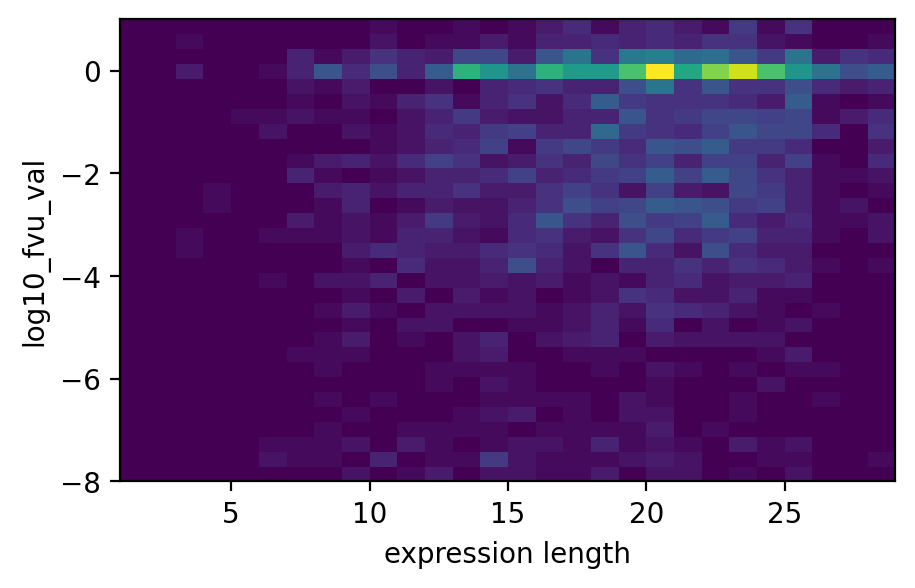

In [17]:
x = results[model_name]['results']['pool_15_10'][n]['expression_length']
y = results[model_name]['results']['pool_15_10'][n]['log10_fvu_val']

x_median, x_lower, x_upper, y_median, y_lower, y_upper = np.array(x_median), np.array(x_lower), np.array(x_upper), np.array(y_median), np.array(y_lower), np.array(y_upper)

fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=200)

ax.hist2d(x, y, bins=(np.unique(x[np.isfinite(x)]), np.linspace(-8, 1, 32)));
ax.set_xlabel('expression length')
ax.set_ylabel('log10_fvu_val')


Text(0, 0.5, 'log10_fvu_val')

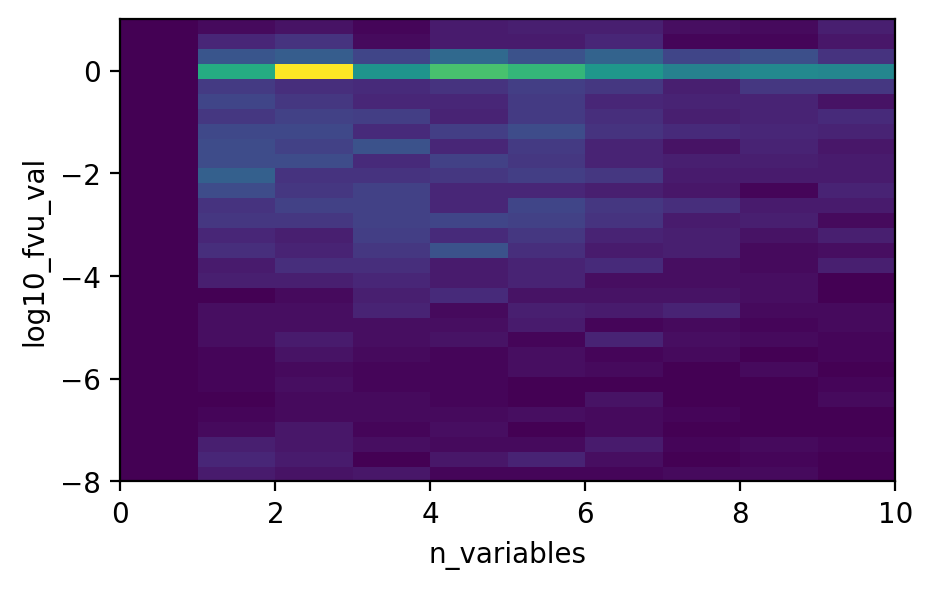

In [18]:
x = results[model_name]['results']['pool_15_10'][n]['n_variables']
y = results[model_name]['results']['pool_15_10'][n]['log10_fvu_val']

fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=200)

ax.hist2d(x, y, bins=(np.unique(x[np.isfinite(x)]), np.linspace(-8, 1, 32)));
ax.set_xlabel('n_variables')
ax.set_ylabel('log10_fvu_val')